# Exploring Dataset

In [1]:
import torch

In [2]:
# import libraries
import numpy as np
import pandas as pd
import numpy as np
import random
import scipy.fft as fft
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()
plt.rcParams["figure.figsize"] = (10,8)

from sklearn.preprocessing import StandardScaler

from matplotlib.lines import Line2D

def standarize(x):
    return (np.array(x)-np.mean(x))/np.std(x)

def euclidean_distance(x1,x2):
    return np.linalg.norm(x1-x2)

def drop_top_right(data, rx_positions):
    idxx = rx_positions[:,0] > 400
    idxy = rx_positions[:,1] > 200
    idx = np.logical_and(idxx, idxy)
    good_idcs = ~idx
    return data[good_idcs]

def distance_matrix(x):
    x = torch.Tensor(x)
    n = x.size(0)
    d = x.size(1)
    try:
        c = x.size(2)
    except:
        c=1
        
    x_1 = x.unsqueeze(1).expand(n, n, d, c)
    x_2 = x.unsqueeze(0).expand(n, n, d, c)

    return torch.pow(x_1 - x_2, 2).sum((2, 3))

In [3]:
# load raw data
data = np.load("../Data/RayTracingData/Remcom_4x4_IR_100taps.npy")
# fft and smooth our data to reduce noise
data_fft = fft.fft(data)[:,:,::2]
# load receiver positions
rx_positions = np.load("../Data/RayTracingData/Remcom_4x4_rxpos.npy")
# load transmitter positions
tx_positions = np.load("../Data/RayTracingData/Remcom_4x4_txpos.npy")
# load Phi and Theta
phi = np.load('../Data/RayTracingData/Remcom_4x4_AoA_phi.npy')
theta = np.load('../Data/RayTracingData/Remcom_4x4_AoA_theta.npy')

In [4]:
data_fft_im_r = np.hstack([np.real(data_fft), np.imag(data_fft) ])
data_fft_im_r.shape

(23922, 32, 50)

In [5]:
# Standartize data
scaler = StandardScaler()
data_fft_scaled = scaler.fit_transform(np.real(data_fft).reshape(data_fft.shape[0], -1)).reshape(data_fft.shape)
phi_scaled = scaler.fit_transform(np.real(phi).reshape(phi.shape[0], -1)).reshape(phi.shape)
theta_scaled = scaler.fit_transform(np.real(theta).reshape(theta.shape[0], -1)).reshape(theta.shape)

In [6]:
data_fft_scaled = drop_top_right(data_fft_scaled, rx_positions)
phi_scaled = drop_top_right(phi_scaled, rx_positions)
theta_scaled = drop_top_right(theta_scaled, rx_positions)

In [7]:
# undersample our data to work a bit faster
indices = random.sample(range(0,len(data_fft_scaled)), 1000)
data_fft_scaled = data_fft_scaled[indices]
phi_scaled = phi_scaled[indices]
theta_scaled = theta_scaled[indices]
# and keep only x and y positions
positions_rx_undersample = rx_positions[indices,:2]
positions_tx = tx_positions[:2]

## Receiver and Transmitter Positions

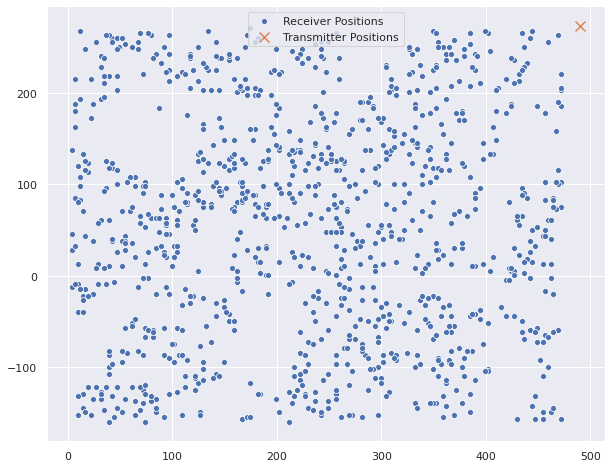

In [8]:
sns.scatterplot(positions_rx_undersample[:,0], positions_rx_undersample[:,1], label='Receiver Positions')
plt.scatter(positions_tx[0][0], positions_tx[0][1], s=100, marker='x', label='Transmitter Positions')
plt.legend()

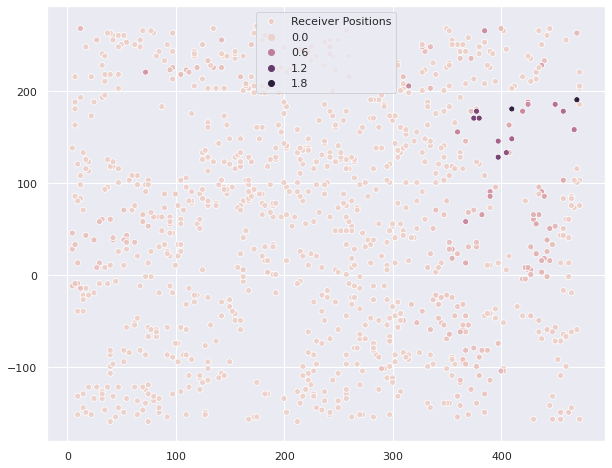

In [23]:
frq_means = np.mean(np.mean(np.abs(data_fft_scaled), axis=2), axis=1)
sns.scatterplot(positions_rx_undersample[:,0], positions_rx_undersample[:,1], hue=frq_means, label='Receiver Positions')

In [9]:
i = 10
example_signal_1 = data_fft_scaled[i]
example_phi_1 = phi_scaled[i]
example_theta_1 = theta[i]
example_signal_2 = data_fft_scaled[i+50]
example_pos = positions_rx_undersample[i,:]

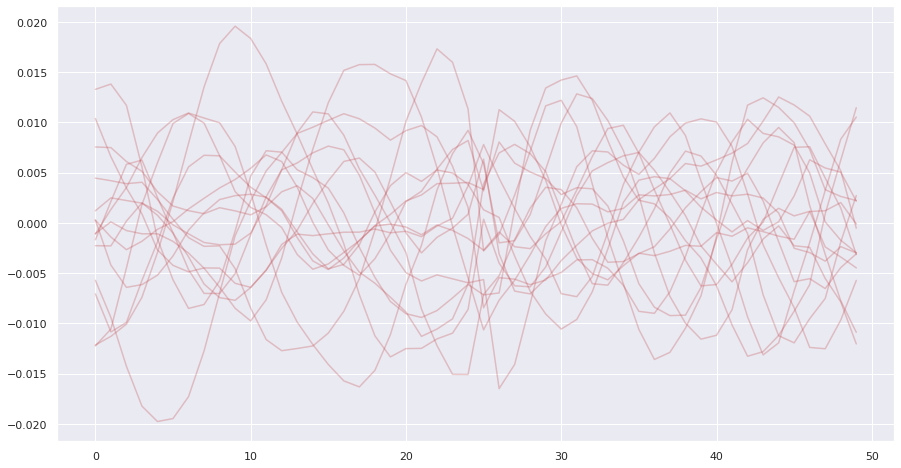

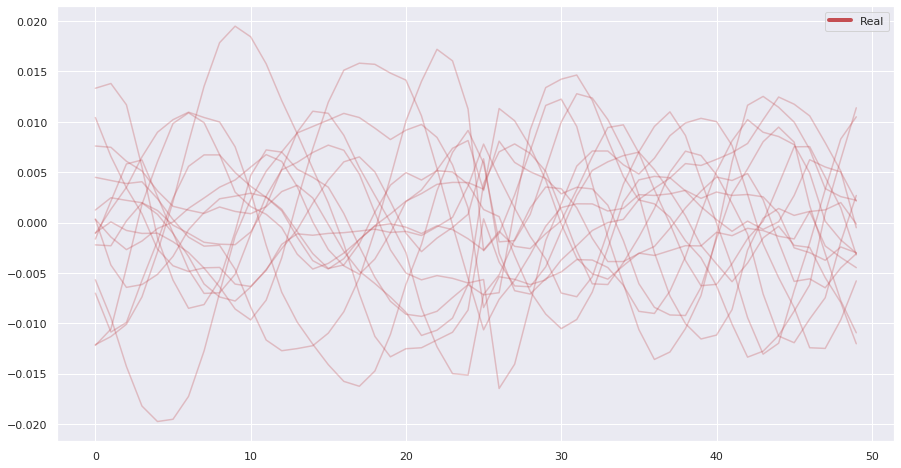

In [45]:
plt.figure(figsize=(15,8))
for i in range(15):
    plt.plot(np.real(example_signal_1[i]), alpha=0.3, c='r')
    #plt.plot(np.imag(example_signal_1[i]), alpha=0.3, c='g')
#plt.plot(np.real(np.mean(example, axis=0)))
#plt.plot(np.imag(np.mean(example, axis=0)))


legend_elements = [Line2D([0], [0], color='r', lw=4, label='Real'),
                   Line2D([0], [0], color='g', lw=4, label='Imaginary')]

plt.figure(figsize=(15,8))
for i in range(15):
    plt.plot(np.real(example_signal_2[i]), alpha=0.3, c='r')
    #plt.plot(np.imag(example_signal_2[i]), alpha=0.3, c='g')
#plt.plot(np.real(np.mean(example, axis=0)))
#plt.plot(np.imag(np.mean(example, axis=0)))


legend_elements = [Line2D([0], [0], color='r', lw=4, label='Real'),
              #     Line2D([0], [0], color='g', lw=4, label='Imaginary')
                  ]


plt.legend(handles=legend_elements)
  

## Calculate Distance From Example
Here we calculate euclidean distance from our example both in the frequency space and in the real space. 

### Euclidean Distance

In [46]:
freq_distance_from_example = np.array([euclidean_distance(example_signal_1,x) for x in data_fft_scaled])
phi_distance_from_example = np.array([euclidean_distance(example_phi_1,x) for x in phi_scaled])
theta_distance_from_example = np.array([euclidean_distance(example_theta_1,x) for x in theta_scaled])
real_distance = np.array([euclidean_distance(example_pos, pos) for pos in positions_rx_undersample])
distance_from_transmitter = np.array([euclidean_distance(tx_positions[0,:2], pos) for pos in positions_rx_undersample])

In [47]:
#mask = np.isnan(phi_distance_from_example)
#freq_distance_from_example = freq_distance_from_example[~mask]
#real_distance = real_distance[~mask]
#distance_from_transmitter = distance_from_transmitter[~mask]

In [48]:
# Make them similar scale
freq_distance_from_example = standarize(freq_distance_from_example)
real_distance = standarize(real_distance)
distance_from_transmitter = standarize(distance_from_transmitter)

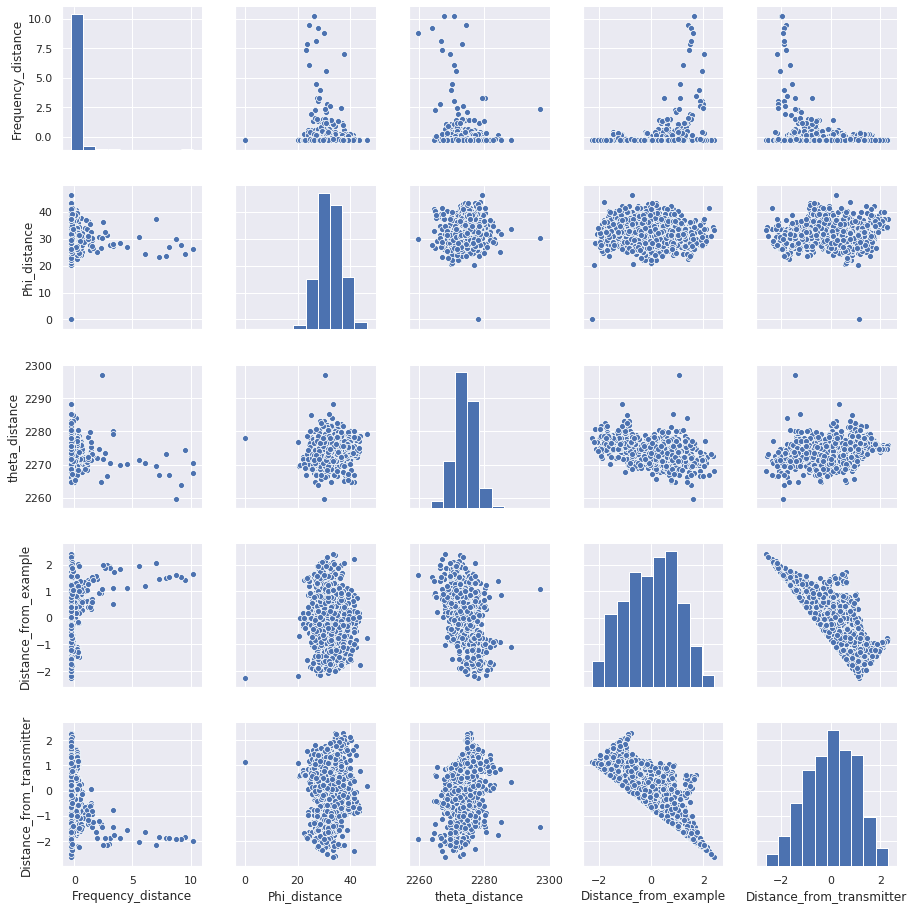

In [49]:
df = pd.DataFrame()
df['Frequency_distance'] = freq_distance_from_example
df['Phi_distance'] = phi_distance_from_example
df['theta_distance'] = theta_distance_from_example
df['Distance_from_example'] = real_distance
df['Distance_from_transmitter'] = distance_from_transmitter
sns.pairplot(df)

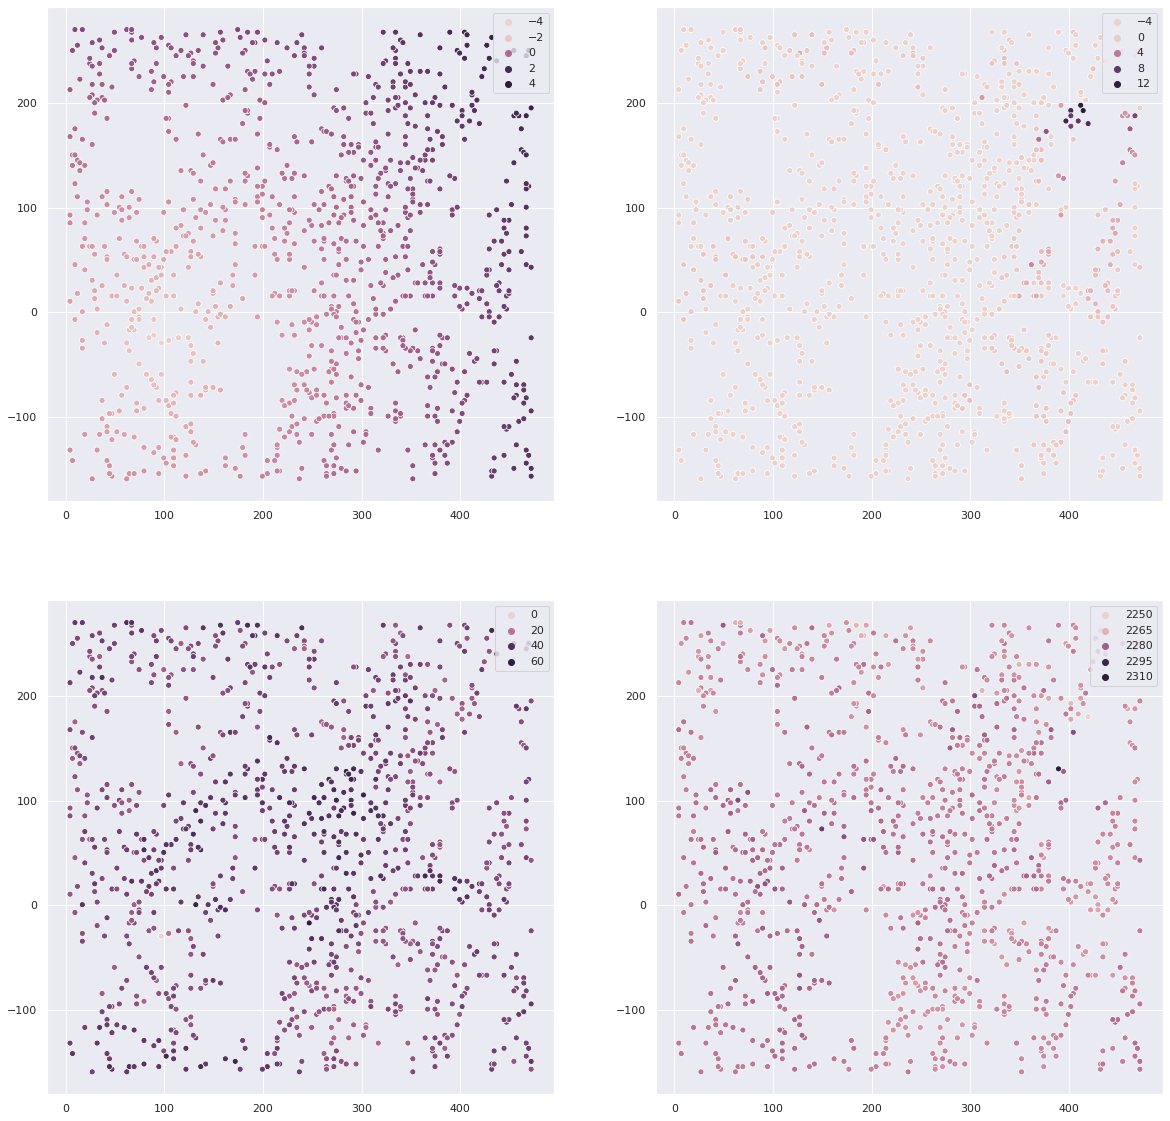

In [50]:
plt.figure(figsize=(20,20))
plt.subplot(2,2,1)
sns.scatterplot(positions_rx_undersample[:,0], positions_rx_undersample[:,1], hue=real_distance)
plt.subplot(2,2,2)
sns.scatterplot(positions_rx_undersample[:,0], positions_rx_undersample[:,1], hue=freq_distance_from_example)
plt.subplot(2,2,3)
sns.scatterplot(positions_rx_undersample[:,0], positions_rx_undersample[:,1], hue=phi_distance_from_example)
plt.subplot(2,2,4)
sns.scatterplot(positions_rx_undersample[:,0], positions_rx_undersample[:,1], hue=theta_distance_from_example)

In [51]:
import torch
phi_distance_matrix = distance_matrix(phi_scaled)
freq_distance_matrix = distance_matrix(data_fft_scaled)
theta_distance_matrix = distance_matrix(theta_scaled)

In [52]:
positions = positions_rx_undersample.reshape(*positions_rx_undersample.shape,1)
postions_distance_matrix = distance_matrix(positions)

In [53]:
phi_distances = phi_distance_matrix.flatten()
freq_distances = freq_distance_matrix.flatten()
theta_distances = theta_distance_matrix.flatten()
pos_distaces = postions_distance_matrix.flatten()

Text(0, 0.5, 'Paiwise phi distance')

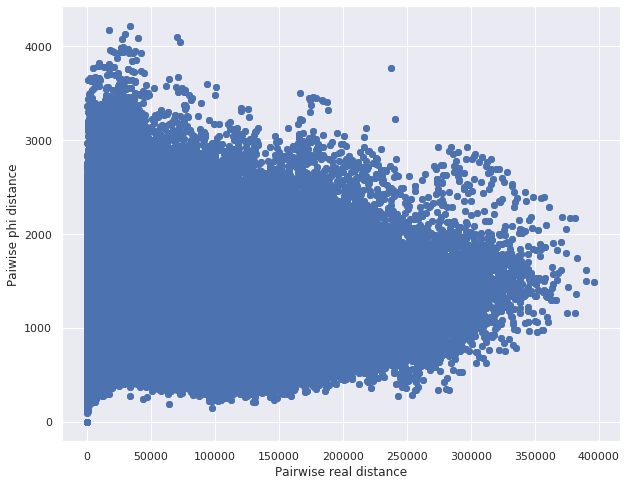

In [54]:
plt.scatter(pos_distaces, phi_distances)
plt.xlabel("Pairwise real distance")
plt.ylabel("Paiwise phi distance")

Text(0, 0.5, 'Paiwise theta distance')

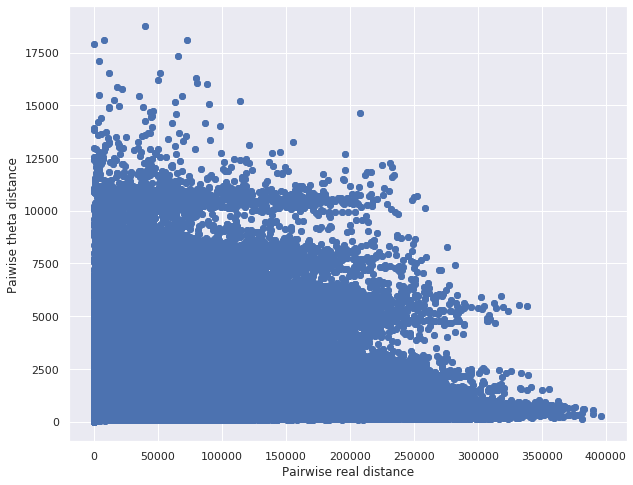

In [55]:
plt.scatter(pos_distaces, theta_distances)
plt.xlabel("Pairwise real distance")
plt.ylabel("Paiwise theta distance")

Text(0, 0.5, 'Paiwise freq distance')

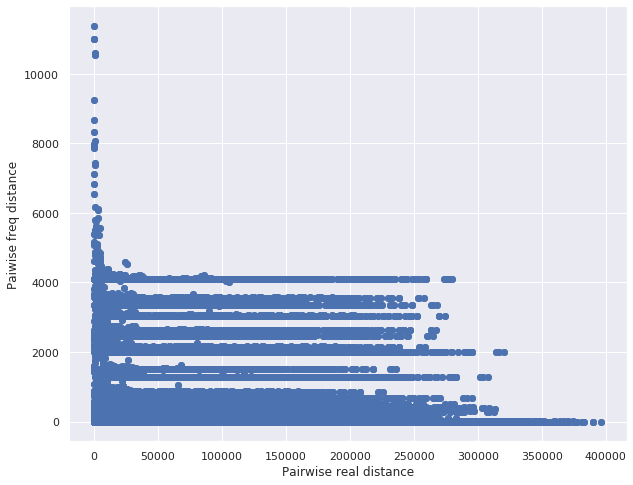

In [56]:
plt.scatter(pos_distaces, freq_distance_matrix)
plt.xlabel("Pairwise real distance")
plt.ylabel("Paiwise freq distance")